In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-11-2022)


In [2]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
)
import sys
import yaml
sys.path.append('../../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [3]:
figformat = 'svg'

In [4]:
dataset_asimov = Dataset_load.create_asimov(gun = True)
simga = 0.2
dataset_asimov.models[0].spectral_model.parameters['sigma'].value = simga
# set npred again
dataset_asimov.counts = dataset_asimov.npred()

update
update


## Single Cases

In [5]:
zero = 1e-12

bias = 0.0
resolution = 0.0
b_assumed = zero
s_assumed = 0.1


def create_dataset(b, s, b_assumed, s_assumed):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        resolution= s,
                        rnd = False,
                        e_reco_creation=10)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(10)
    dataset_conv_N.models.parameters['bias'].frozen  = True
    
    penalising_invcovmatrix = np.zeros((2,2))
    np.fill_diagonal(penalising_invcovmatrix, [1/b_assumed**2, 1/s_assumed**2])#, 1/zero**2, 1/zero**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_conv_N.irf_model.eff_area_model.parameters.freeze_all()
    dataset_conv_N.irf_model.eff_area_model = None

    return dataset_conv, dataset_conv_N

dataset, dataset_N  = create_dataset(bias, resolution, b_assumed, s_assumed)

update
update


In [6]:
case = ''


In [7]:
%%time
fitting = 1
if fitting:
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(dataset)
else:
    path = f'data/2_model_bias_0_{resolution}_simga_{simga}.yml'
    dataset = Dataset_load.load_dataset_N(dataset, path)        

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

In [8]:
%%time
if fitting:
    fit_N = Fit(store_trace=False)
    fit_N.optimize_opts = minuit_opts
    result_N = fit_N.run(dataset_N)
else:
    path = f'data/2_model_nui_bias_0_{resolution}_simga_{simga}.yml'
    dataset_N = Dataset_load.load_dataset_N(datasets_N, path)

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

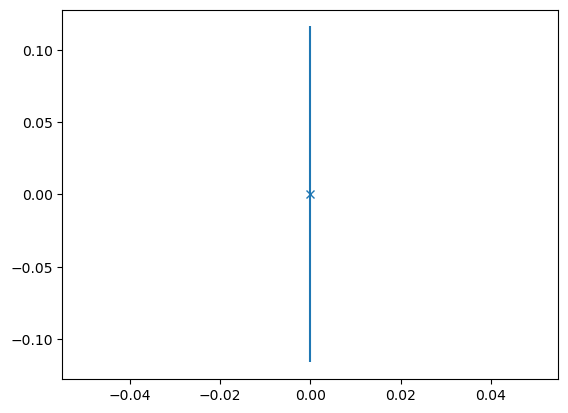

In [9]:
for i, d in enumerate( [dataset_N]):
    value = d.irf_model.parameters['resolution'].value
    error = d.irf_model.parameters['resolution'].error
    plt.errorbar(resolution, value, yerr = error, fmt = 'x')
    

## Stat Profiles for Source Sigma (width of peak)

In [10]:
computing_norm = 1
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [16]:
print(dataset.models.parameters['sigma'])

Parameter(name='sigma', value=0.19980936583203793, factor=1.9980936583203792, scale=0.1, unit=Unit("TeV"), min=nan, max=nan, frozen=False, id=0x7f8b254bc910, is_penalised=False)


In [11]:
%%time
computing_sigma = 0

if computing_sigma:
    sigma = 4
    parameter_i = dataset.models.parameters['sigma']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([dataset], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_sigma'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_sigma'+case+'.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 1.01 ms, sys: 4.01 ms, total: 5.02 ms
Wall time: 1.83 ms


In [22]:
%%time
computing_sigma_N = 1
if computing_sigma_N:
    sigma = 2
    parameter_i = dataset_N.models.parameters['sigma']
    #parameter_i.scan_n_sigma = sigma
    #avoid neg values:
    parameter_i.scan_values = np.linspace(1e-5,
                                          dataset_N.models.parameters['sigma'].value + sigma*dataset_N.models.parameters['sigma'].error,
                                         11)
    stat_profile_N_i = fit.stat_profile(dataset_N, parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5_scan_sigma_N'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5_scan_sigma_N'+case+'.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


update


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


update


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


update


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


update


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


update


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update
update

In [13]:
import sys
sys.path.append(config['local']['path']+'/nuisance_summary/Eff_area')
import upper_limit_18_02

NameError: name 'config' is not defined

In [ ]:
color_standard = 'crimson'; color_standard_e = 'palevioletred'  #mediumvioletred
color_nui = 'navy'; color_nui_e = 'cornflowerblue'
color_input = 'darkorange'
color_rnd = 'darkgreen'


In [ ]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance", color = color_nui)


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard", color = color_standard)

index_err = datasets[0].models[0].parameters['sigma'].error
index_err_N = datasets_N[0].models[0].parameters['sigma'].error




min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.6, 
                label = '1$\sigma_{stat+sys}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({index_err_N:.2})'
                , color = color_nui_e)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.6, 
                label = '1$\sigma_{stat}$' +f' = -{er_neg:.2} +{er_pos:.2} \n({index_err:.2})'
                , color = color_standard_e)

ylim = ax.get_ylim()
ax.vlines(2.3, ylim[0], ylim[1], color = color_input)

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")

fig.savefig("plots/5_stat_scan_sigma.png")

## Stat Profiles for Source Signal

In [ ]:
%%time
computing_amplitude = 0

if computing_amplitude:
    sigma = 3
    parameter_a = datasets[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5_scan_amplitude'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5_scan_amplitude'+case+'.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [ ]:
%%time
if computing_amplitude:
    sigma = 3
    parameter_a = datasets_N[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5_scan_amplitude_N'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5_scan_amplitude_N'+case+'.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [ ]:
fig = plt.figure()
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance",color = color_nui)


ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard", color = color_standard)

amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error



min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.6, 
                label = '1$\sigma_{stat+sys}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})'
                , color = color_nui_e)
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.6, 
                label = '1$\sigma_{stat}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})'
                , color = color_standard_e)


plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")
ylim = ax.get_ylim()
ax.vlines(1e-12, ylim[0], ylim[1], color = color_input)
fig.savefig("plots/5_stat_scan_amplitude.png")

## Stat Profiles for Source Mean

In [ ]:
%%time
computing_lambda = 1

if computing_lambda:
    sigma = 3
    parameter_c = datasets[0].models.parameters['mean']
    parameter_c.scan_n_sigma = sigma
    stat_profile_c = fit.stat_profile([datasets[0]], parameter_c, reoptimize= True)
    stat_profile_c['scale_scan'] = stat_profile_c.pop(next(iter(stat_profile_c)) )    
    with open('data/5_scan_mean_'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_c), file)
    
else:
    with open('data/5_scan_mean_'+case+'.yaml') as file:
        stat_profile_c = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [ ]:
%%time
if computing_lambda:
    sigma = 4
    parameter_c = datasets_N[0].models.parameters['mean']
    parameter_c.scan_n_sigma = sigma
    stat_profile_N_c = fit.stat_profile([datasets_N[0]], parameter_c, reoptimize = True)
    stat_profile_N_c['scale_scan'] = stat_profile_N_c.pop(next(iter(stat_profile_N_c)) )    
    
    with open('data/5_scan_mean_N'+case+'.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_c), file)
    
else:
    with open('data/5_scan_mean_N'+case+'.yaml') as file:
        stat_profile_N_c = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [ ]:
fig = plt.figure()
ll_N_c = stat_profile_N_c.copy()
ul_N_c = upper_limit_18_02.upper_limit(ll_N_c,0,0)
L_N_c, x_N_c = ul_N_c.interpolate()
plt.plot(x_N_c, L_N_c(x_N_c),label = "Nuisance",color = color_nui)


ll_c = stat_profile_c.copy()
ul_c = upper_limit_18_02.upper_limit(ll_c,0,0)
L_c, x_c = ul_c.interpolate()
plt.plot(x_c, L_c(x_c),label = "standard", color = color_standard)

amplitude_err = datasets[0].models[0].parameters['mean'].error
amplitude_err_N = datasets_N[0].models[0].parameters['mean'].error



min_, er_neg, er_pos = ul_N_c.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.6, 
                label = '1$\sigma_{stat+sys}$' +f'  = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})'
                , color = color_nui_e)
min_, er_neg, er_pos = ul_c.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.6, 
                label = '1$\sigma_{stat}$' +f'                = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})'
                , color = color_standard_e)


plt.xlabel("Source Cutoff [1/TeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")
ylim = ax.get_ylim()
ax.vlines(0.1, ylim[0], ylim[1], color = color_input)
fig.savefig("plots/5_stat_scan_mean"+case+".png")